In [74]:
import pandas as pd
import numpy as np
from collections import Counter
from astropy.table import QTable, Table
import astropy.units as u

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from qmostetc import SEDTemplate, QMostObservatory, Filter, L1DXU
import os

In [75]:
col_format_all_S17 = {
    'NAME':pd.StringDtype(),
    'RA':np.float64, 'DEC':np.float64,
    'PMRA':np.float32, 'PMDEC':np.float32,
    'EPOCH':np.float32, 'RESOLUTION':np.int16,
    'SUBSURVEY':pd.StringDtype(),
    'TEMPLATE':pd.StringDtype(), 
    'TEMPLATE_with_MgII':pd.StringDtype(), 
    'RULESET':pd.StringDtype(),
    'EXTENT_FLAG':np.int32,
    'EXTENT_PARAMETER':np.float32,'EXTENT_INDEX':np.float32,
    'MAG_TYPE':pd.StringDtype(),
    'MAG':np.float32, 'MAG_ERR':np.float32,
    'DATE_EARLIEST':np.float64, 'DATE_LATEST':np.float64,
    'CADENCE':np.int64,
    'REDDENING':np.float32,
    'REDSHIFT_ESTIMATE':np.float32,
    'REDSHIFT_ERROR':np.float32,
    'CAL_MAG_ID_BLUE':pd.StringDtype(),
    'CAL_MAG_ID_GREEN':pd.StringDtype(),
    'CAL_MAG_ID_RED':pd.StringDtype(),
    'CAL_MAG_ERR_BLUE':np.float32,
    'CAL_MAG_ERR_GREEN':np.float32,
    'CAL_MAG_ERR_RED':np.float32,
    'CAL_MAG_BLUE':np.float32,
    'CAL_MAG_GREEN':np.float32,
    'CAL_MAG_RED':np.float32,
    'CLASSIFICATION':pd.StringDtype(),
    'CLASS_SPEC':pd.StringDtype(),
    'COMPLETENESS':np.float32,
    'PARALLAX':np.float32,
    'SWEEP_NAME':pd.StringDtype(), 
    'BRICKNAME':pd.StringDtype(), 
    'TYPE':pd.StringDtype(), 
    'BAND_LEGACY':pd.StringDtype(), 
    'REFERENCE_BAND':pd.StringDtype(), 
    'COMBINATION_USE':pd.StringDtype(), 
    'REDSHIFT_REF':pd.StringDtype(), 
    'EBV':np.float64, 
    'PLXSIG': np.float64, 
    'PMSIG': np.float64, 
    'SN_MAX': np.float64, 
    'MAG_G': np.float32, 
    'MAGERR_G': np.float32, 
    'MAG_R': np.float32, 
    'MAGERR_R': np.float32, 
    'MAG_I': np.float32, 
    'MAGERR_I': np.float32, 
    'MAG_Z': np.float32, 
    'MAGERR_Z': np.float32, 
    'MAG_Y': np.float32, 
    'MAGERR_Y': np.float32, 
    'MAG_J': np.float32, 
    'MAGERR_J': np.float32, 
    'MAG_H': np.float32, 
    'MAGERR_H': np.float32, 
    'MAG_K': np.float32, 
    'MAGERR_K': np.float32, 
    'MAG_W1': np.float32, 
    'MAGERR_W1': np.float32, 
    'MAG_W2': np.float32, 
    'MAGERR_W2': np.float32, 
    'SPECTYPE_DESI': pd.StringDtype()
    }

col_units = {
    "RA": "deg", "DEC": "deg", "PMRA": "mas/yr", "PMDEC": "mas/yr",
    "EPOCH": "yr", "MAG": "mag", "MAG_ERR": "mag", "EXTENT_PARAMETER": "arcsec",
    "DATE_EARLIEST": "d", "DATE_LATEST": "d", "REDDENING": "mag",
    "CAL_MAG_BLUE": "mag", "CAL_MAG_GREEN": "mag", "CAL_MAG_RED": "mag",
    "CAL_MAG_ERR_BLUE": "mag", "CAL_MAG_ERR_GREEN": "mag", "CAL_MAG_ERR_RED": "mag",
    "PARALLAX": "mas",
}

In [76]:
def cols_format_dict(format_dict, dataframe):
    matching_columns = {}
    
    for col in dataframe.columns:
        if col in format_dict:
            matching_columns[col] = format_dict[col]
    
    return matching_columns

def format_pd_for_fits(df):
    
    df_copy = df.copy()
    
    for col_name in df_copy.columns:  # object to string

        col_values = df_copy[col_name].values

        if col_values.dtype == 'object':
            df_copy[col_name] = df_copy[col_name].astype(pd.StringDtype())

    format_cols = cols_format_dict(col_format_all_S17, df_copy)
    df_copy = df_copy.astype(format_cols)

    for col_name in df_copy.columns:  # fill empty cells

        col_series = df_copy[col_name].values

        if pd.api.types.is_string_dtype(df_copy[col_name]) or isinstance(col_series.dtype, pd.StringDtype):
            df_copy[col_name] = df_copy[col_name].fillna('-')
        else:
            if col_name in ['MAG_Z', 'MAG', 'MAGERR_Z', 'MAG_ERR', 'MAG_G', 'CAL_MAG_BLUE', 
                            'MAGERR_G', 'CAL_MAG_ERR_BLUE', 'MAG_R', 'CAL_MAG_GREEN', 'MAGERR_R', 'CAL_MAG_ERR_GREEN', 
                            'MAG_I', 'CAL_MAG_RED', 'MAGERR_I', 'CAL_MAG_ERR_RED']:
                df_copy[col_name] = df_copy[col_name].fillna(1.0)
            else:
                df_copy[col_name] = df_copy[col_name].fillna(-999)
    
    df_copy.reset_index(drop=True, inplace=True)
    return df_copy

def save_to_fits(df, filepath, meta=None):

    df_for_fits = format_pd_for_fits(df)
    
    t = Table()

    format_cols = cols_format_dict(col_format_all_S17, df_for_fits)
    for col_name in df_for_fits.columns:
        if col_name in format_cols.keys():
            col_data = df_for_fits[col_name].astype(col_format_all_S17[col_name])
            col_data = col_data.values
        else:
            col_data = df_for_fits[col_name].values

        if hasattr(col_data, 'values'):
            t[col_name] = col_data.values
        else:
            t[col_name] = [x for x in col_data]
            
    if meta:
        t.meta.update(meta)

    t.write(filepath, format='fits', overwrite=True)

def pandas_from_fits(filepath):
    t = Table.read(filepath, format='fits')
    
    t = t.to_pandas()

    format_cols = cols_format_dict(col_format_all_S17, t)
    t = t.astype(format_cols)

    return t

# SNR bins

In [ ]:
z = 1.5

In [ ]:
from simulate_quasars_no_abs import simulate_quasars

In [27]:
simulate_quasars(1, [z], ['QSO_for_SNR'], output_dir='./../SNR/QSO_model')

Using 1 provided redshifts
Creating quasar models:


100%|██████████| 1/1 [00:00<00:00, 274.48it/s]


ID,REDSHIFT,absMag,smcDustEBV,LOG_MBH,LOG_REDD,NAME
str24,float32,float32,float32,float64,float64,str11
QSO_sim_z1.5_QSO_for_SNR,1.5,-23.061964,0.062106147,8.141895142387893,-0.8032895437592349,QSO_for_SNR


In [28]:
moon = 'gray'
texp = 47 * u.min

In [29]:
mags = [15.0, 17.0, 19.0, 20.5, 21.5]
fobs = [2., 3., 5., 10., 20., 40.]

In [40]:
def process_quasar(mag_value, t_exp, fobs, target_name='QSO_z_1_5_for_SNR', z=1.5, mag_type_str='DECAM_z_AB', 
                    output_dir='./../SNR/ETC_output', 
                    template_path='./../SNR/QSO_model/', template_name='QSO_sim_z1.5_QSO_for_SNR.fits', 
                    airmass=1.2,  # 1.0 - 1.5
                    seeing=0.8,  # 0.4 - 1.5
                    moon='gray',
                    CR_rate=1.67e-7, #l1_type='joined', 
                    prog_id='4MOST-ETC'):

    spectrograph = 'hrs'
    qmost = QMostObservatory(spectrograph)

    alt = np.arccos(1. / airmass) * 180 / np.pi * u.deg
    obs = qmost(alt, seeing*u.arcsec, moon)

        # ruleset_name = row['RULESET']
        # target_name = row['NAME']
        # ruleset = rulesets[ruleset_name]
        # etc = ruleset.etc(alt, seeing*u.arcsec, moon)
    template_fname = os.path.join(template_path, template_name)
    SED = SEDTemplate(template_fname)

        # Add the target spectrum from the template with a magnitude
    # mag_type_str = row['MAG_TYPE']
    survey, band, ab_vega = mag_type_str.split('_')
    mag_type = [filt_id for filt_id in Filter.list()
                if survey.upper() in filt_id.upper() and '.'+band in filt_id][0]
    mag_unit = u.ABmag
        # if ab_vega != 'AB':
        #     print("Warning not AB magnitude in catalog... may be incorrect")
    mag = mag_value * mag_unit
        # SED = SED.redshift(row['REDSHIFT_ESTIMATE'])
        # etc.set_target(SED(mag, mag_type), 'point')
    obs.set_target(SED(mag, mag_type), 'point')

    texp_fobs = t_exp * fobs
    res = obs.expose(texp_fobs)
    if np.isnan(res['target']).any():
        res['target'][np.isnan(res['target'])] = 0.
    if np.isnan(res['sky']).any():
        res['sky'][np.isnan(res['sky'])] = 0.

    # Add cosmic rays:
    N_pix = len(res)
    N_cosmic = np.random.poisson(CR_rate * texp.value * N_pix * 0.8)
    idx = np.random.choice(np.arange(N_pix), N_cosmic, replace=False)
    CR_boost = 10**np.random.normal(2.0, 0.15, N_cosmic) * u.electron
    res['target'][idx] += CR_boost
    res['noise'][idx] = np.sqrt(res['noise'][idx]**2 + CR_boost * u.electron)

    dxu = L1DXU(qmost, res, texp)

    z_str = str(np.round(z, 4))
    mag_str = str(np.round(mag_value, 2))
    fobs_str = str(np.round(fobs, 3))
    model_id = f'QSO_sim_ETC_z{z_str}_mag{mag_str}_fobs{fobs_str}'
    filename = f"{model_id}_LJ1.fits"

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    output = os.path.join(output_dir, filename)
    print(model_id)
    try:
        hdu_list = dxu.joined()
        hdu_list.writeto(output, overwrite=True)
    # except ValueError as e:
    #     print(f"Failed to save the joined spectrum: {row['TEMPLATE']}")
    except (ValueError, IndexError) as e:
        print(f"\nFailed to save the joined spectrum for {target_name} (z={z}): {str(e)}")

    return [filename, mag_value, texp.value, fobs, texp_fobs.value, seeing, airmass]

In [ ]:
etc_snr = pd.DataFrame(columns=['filename', 'mag', 'texp', 'fobs', 'texp_x_fobs'])

for mag in mags:
    for fob in fobs:
        filename_, mag_value_, texp_, fobs_, texp_fobs_, seeing_, airmass_ = process_quasar(mag, texp, fob)
        etc_snr.loc[etc_snr.shape[0]] = [filename_, mag_value_, texp_, fobs_, texp_fobs_]

etc_snr

QSO_sim_ETC_z1.5_mag15.0_fobs2.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag15.0_fobs3.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag15.0_fobs5.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag15.0_fobs10.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag15.0_fobs20.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag15.0_fobs40.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag17.0_fobs2.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag17.0_fobs3.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag17.0_fobs5.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag17.0_fobs10.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag17.0_fobs20.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag17.0_fobs40.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag19.0_fobs2.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag19.0_fobs3.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag19.0_fobs5.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag19.0_fobs10.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag19.0_fobs20.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag19.0_fobs40.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag20.5_fobs2.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag20.5_fobs3.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag20.5_fobs5.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag20.5_fobs10.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag20.5_fobs20.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag20.5_fobs40.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag21.5_fobs2.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag21.5_fobs3.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag21.5_fobs5.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag21.5_fobs10.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag21.5_fobs20.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


QSO_sim_ETC_z1.5_mag21.5_fobs40.0


/opt/anaconda3/envs/etc_4fs/lib/python3.13/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


,filename,mag,texp,fobs,texp_x_fobs
0,QSO_sim_ETC_z1.5_mag15.0_fobs2.0_LJ1.fits,15.0,47.0,2.0,94.0
1,QSO_sim_ETC_z1.5_mag15.0_fobs3.0_LJ1.fits,15.0,47.0,3.0,141.0
2,QSO_sim_ETC_z1.5_mag15.0_fobs5.0_LJ1.fits,15.0,47.0,5.0,235.0
3,QSO_sim_ETC_z1.5_mag15.0_fobs10.0_LJ1.fits,15.0,47.0,10.0,470.0
4,QSO_sim_ETC_z1.5_mag15.0_fobs20.0_LJ1.fits,15.0,47.0,20.0,940.0
5,QSO_sim_ETC_z1.5_mag15.0_fobs40.0_LJ1.fits,15.0,47.0,40.0,1880.0
6,QSO_sim_ETC_z1.5_mag17.0_fobs2.0_LJ1.fits,17.0,47.0,2.0,94.0
7,QSO_sim_ETC_z1.5_mag17.0_fobs3.0_LJ1.fits,17.0,47.0,3.0,141.0
8,QSO_sim_ETC_z1.5_mag17.0_fobs5.0_LJ1.fits,17.0,47.0,5.0,235.0
9,QSO_sim_ETC_z1.5_mag17.0_fobs10.0_LJ1.fits,17.0,47.0,10.0,470.0


In [55]:
etc_snr.head()

,filename,mag,texp,fobs,texp_x_fobs
0,QSO_sim_ETC_z1.5_mag15.0_fobs2.0_LJ1.fits,15.0,47.0,2.0,94.0
1,QSO_sim_ETC_z1.5_mag15.0_fobs3.0_LJ1.fits,15.0,47.0,3.0,141.0
2,QSO_sim_ETC_z1.5_mag15.0_fobs5.0_LJ1.fits,15.0,47.0,5.0,235.0
3,QSO_sim_ETC_z1.5_mag15.0_fobs10.0_LJ1.fits,15.0,47.0,10.0,470.0
4,QSO_sim_ETC_z1.5_mag15.0_fobs20.0_LJ1.fits,15.0,47.0,20.0,940.0


In [57]:
def get_SNR(row):
    spec = Table.read('./../SNR/ETC_output/' + row['filename'])

    flux = spec['FLUX'].data[0]
    error = spec['ERR_FLUX'].data[0]

    snr_pixel = flux / error
    spec['SNR_per_pixel'] = [snr_pixel]
    mean_snr_pixel = np.nanmean(snr_pixel)

    snr_ang = snr_pixel * 3.3  # SNR per Ang / 3.3 = SNR per px, from User manual p. 10
    spec['SNR_per_ang'] = [snr_ang]
    mean_snr_ang = np.nanmean(snr_ang)

    spec.write('./../SNR/ETC_output/' + row['filename'], overwrite=True)

    return mean_snr_pixel, mean_snr_ang

In [59]:
etc_snr[['mean_snr_per_pixel', 'mean_snr_per_ang']] = etc_snr.apply(lambda x: pd.Series(get_SNR(x)), axis=1)
etc_snr

,filename,mag,texp,fobs,texp_x_fobs,mean_snr_per_pixel,mean_snr_per_ang
0,QSO_sim_ETC_z1.5_mag15.0_fobs2.0_LJ1.fits,15.0,47.0,2.0,94.0,35.539036,117.278809
1,QSO_sim_ETC_z1.5_mag15.0_fobs3.0_LJ1.fits,15.0,47.0,3.0,141.0,43.620220,143.946716
2,QSO_sim_ETC_z1.5_mag15.0_fobs5.0_LJ1.fits,15.0,47.0,5.0,235.0,56.428688,186.214676
3,QSO_sim_ETC_z1.5_mag15.0_fobs10.0_LJ1.fits,15.0,47.0,10.0,470.0,79.897736,263.662537
4,QSO_sim_ETC_z1.5_mag15.0_fobs20.0_LJ1.fits,15.0,47.0,20.0,940.0,113.059090,373.094971
5,QSO_sim_ETC_z1.5_mag15.0_fobs40.0_LJ1.fits,15.0,47.0,40.0,1880.0,159.963638,527.879944
6,QSO_sim_ETC_z1.5_mag17.0_fobs2.0_LJ1.fits,17.0,47.0,2.0,94.0,12.688695,41.872692
7,QSO_sim_ETC_z1.5_mag17.0_fobs3.0_LJ1.fits,17.0,47.0,3.0,141.0,15.712529,51.851353
8,QSO_sim_ETC_z1.5_mag17.0_fobs5.0_LJ1.fits,17.0,47.0,5.0,235.0,20.473156,67.561417
9,QSO_sim_ETC_z1.5_mag17.0_fobs10.0_LJ1.fits,17.0,47.0,10.0,470.0,29.151886,96.201225


In [ ]:
# etc_snr.to_csv('./../SNR/SNR_per_mag_and_fobs.csv', index=False)

<Axes: >

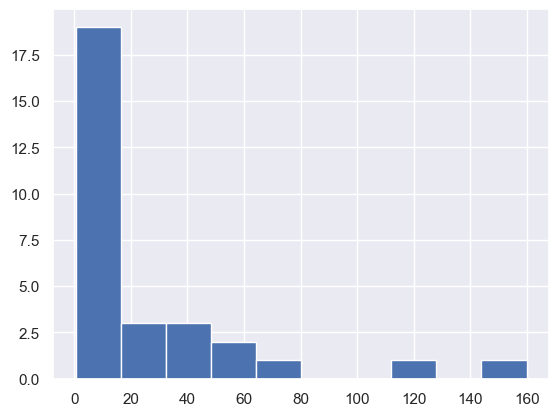

In [79]:
etc_snr.mean_snr_per_pixel.hist()

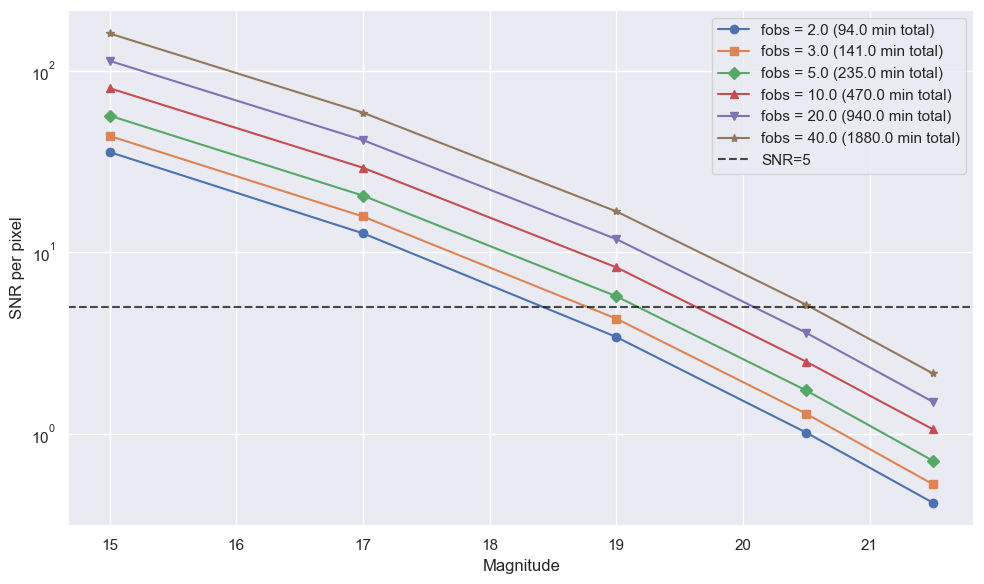

In [ ]:
plt.figure(figsize=(10, 6))

markers = ['o', 's', 'D', '^', 'v', '*']

for i, fob in enumerate(fobs):

    data = etc_snr[etc_snr['fobs'] == fob]

    plt.plot(data['mag'], data['mean_snr_per_pixel'], marker=markers[i], 
             label=f'fobs = {fob} ({fob * texp.value} min total)'
             )

    for snr in data['mean_snr_per_pixel']:
        if snr < 0.0:
            print(snr)

plt.axhline(y=5, color='black', linestyle='--', alpha=0.7, label='SNR=5')

plt.yscale('log')

plt.xlabel('Magnitude', fontsize=12)
plt.ylabel('SNR per pixel', fontsize=12)

plt.legend(loc='upper right')

plt.tight_layout()

# plt.savefig('./../SNR/SNR_vs_fobs_mag.png', dpi=400)

plt.show()

# SNR of the whole catalogue

In [77]:
def spec_name(row, with_mgii=False):
    z_str = str(np.round(row['REDSHIFT_ESTIMATE'], 4))
    mag_str = str(np.round(row['MAG'], 2))
    ruleset_name = row['RULESET']
    target_name = row['NAME']
    if with_mgii:
        model_id = f'QSO_sim_ETC_z{z_str}_mag{mag_str}_{target_name}_LJ1_with_MgII.fits'
    else:
        model_id = f'QSO_sim_ETC_z{z_str}_mag{mag_str}_{target_name}_LJ1.fits'
    return model_id

In [78]:
cat = pandas_from_fits('/data2/home2/nguerrav/Catalogues/ByCycle_Final_Cat_fobs_qso_templates_with_SNR.fits')
cat.head()

,SWEEP_NAME,INDEX_SWEEP,BRICKNAME,OBJID,TYPE,RA,DEC,EBV,SN_MAX,PLXSIG,...,CAL_MAG_ID_BLUE,CAL_MAG_ID_GREEN,CAL_MAG_ID_RED,RULESET,NAME,fobs,SNR_mean,SNR_blue_mean,SNR_green_mean,SNR_red_mean
0,000m030-005m025,16955.0,0029m287,425.0,REX,2.854988,-28.867229,0.016329,70.079727,-99.000000,...,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,Fixed_BG_NOISE_0p33hr_Rulesets,MgIIBlueDeep_2.855m28.8672,1.112188,0.469754,0.415968,0.533687,0.459892
1,000m030-005m025,21473.0,0029m287,5019.0,REX,2.995691,-28.635296,0.013518,93.950668,-99.000000,...,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,Fixed_BG_NOISE_0p33hr_Rulesets,MgIIBlueDeep_2.9957m28.6353,1.272858,0.307231,0.175061,0.347418,0.397552
2,000m030-005m025,21547.0,0029m287,5097.0,PSF,2.998681,-28.695906,0.014227,111.909660,-99.000000,...,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,Fixed_BG_NOISE_0p33hr_Rulesets,MgIIBlueDeep_2.9987m28.6959,1.252395,0.589569,0.317091,0.629089,0.818222
3,000m030-005m025,21765.0,0029m287,5323.0,SER,3.007118,-28.631196,0.013384,175.493042,-99.000000,...,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,Fixed_BG_NOISE_0p33hr_Rulesets,MgIIBlueDeep_3.0071m28.6312,4.838731,0.895251,0.525017,0.925685,1.228731
4,000m030-005m025,24879.0,0029m287,8506.0,PSF,3.104241,-28.746363,0.013091,200.720352,0.052104,...,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,Fixed_BG_NOISE_0p33hr_Rulesets,MgIIBlueDeep_3.1042m28.7464,7.592981,0.846860,0.522841,0.850583,1.161161


In [ ]:
# save_to_fits(cat, '/data2/home2/nguerrav/Catalogues/ByCycle_Final_Cat_fobs_qso_templates_with_SNR_with_some_neg_snrs.fits')

In [ ]:
# cat_snr_ok = cat.loc[cat.SNR_mean >= 0.0]
# cat_snr_ok.reset_index(drop=True, inplace=True)
# cat_snr_ok.shape

(1334238, 85)

In [ ]:
# save_to_fits(cat_snr_ok, '/data2/home2/nguerrav/Catalogues/ByCycle_final_SNR_ok.fits')

In [9]:
cat.columns

Index(['SWEEP_NAME', 'INDEX_SWEEP', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC',
       'EBV', 'SN_MAX', 'PLXSIG', 'PMSIG', 'BAND_LEGACY', 'REFERENCE_BAND',
       'COMBINATION_USE', 'CAL_MAG_BLUE', 'CAL_MAG_GREEN', 'CAL_MAG_RED',
       'MAG', 'CAL_MAG_ERR_BLUE', 'CAL_MAG_ERR_GREEN', 'CAL_MAG_ERR_RED',
       'MAG_ERR', 'MAG_Y', 'MAG_J', 'MAG_H', 'MAG_K', 'MAGERR_Y', 'MAGERR_J',
       'MAGERR_H', 'MAGERR_K', 'MAG_W1', 'MAG_W2', 'MAGERR_W1', 'MAGERR_W2',
       'P_QSO', 'REDSHIFT_ESTIMATE', 'Z1_QSO', 'Z2_QSO', 'P_QSO_Z', 'P_GALAXY',
       'PHOTOZ_GALAXY', 'Z1_GALAXY', 'Z2_GALAXY', 'P_GALAXY_Z', 'P_STAR',
       'RATIO', 'CLASS_SPEC', 'Z_SPEC', 'REDSHIFT_ERROR', 'REDSHIFT_REF', 'l',
       'b', 'pm', 'PMRA', 'PMDEC', 'pmra_error', 'pmdec_error', 'Z_DESI',
       'SPECTYPE_DESI', 'SUBSURVEY', 'EPOCH', 'RESOLUTION', 'CADENCE',
       'TEMPLATE', 'EXTENT_FLAG', 'EXTENT_PARAMETER', 'EXTENT_INDEX',
       'REDDENING', 'TEMPLATE_REDSHIFT', 'DATE_EARLIEST', 'DATE_LATEST',
       'CLASSIFICATIO

## Define golden sample

In [79]:
cat.loc[(cat['fobs']>= 5.0) & (cat['MAG'] <= 20.0)].shape

(16495, 85)

In [80]:
cat['golden'] = False
cat.loc[(cat['fobs']>= 5.0) & (cat['MAG'] <= 20.0), 'golden'] = True
Counter(cat['golden'])

Counter({False: 1344988, True: 16495})

In [81]:
golden = cat.loc[cat['golden']]
golden.reset_index(drop=True, inplace=True)
golden.shape

(16495, 86)

In [82]:
golden = golden.loc[golden.SNR_mean >= 0.0]
golden.reset_index(drop=True, inplace=True)
golden.shape

(16175, 86)

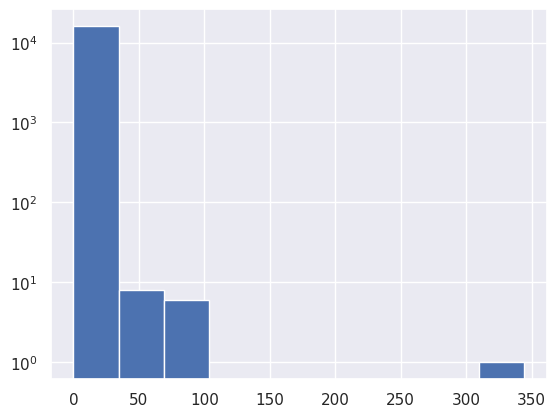

In [12]:
golden.SNR_mean.hist()
plt.yscale('log')

In [38]:
golden.to_csv('/data2/home2/nguerrav/Catalogues/golden_sample_ByCycle.csv', index=False)

In [83]:
not_golden = cat.loc[cat['golden'] == False]
not_golden.reset_index(drop=True, inplace=True)
not_golden.shape

(1344988, 86)

In [84]:
not_golden = not_golden.loc[not_golden.SNR_mean >= 1.0]
not_golden.reset_index(drop=True, inplace=True)
not_golden.shape

(592776, 86)

In [85]:
save_to_fits(not_golden, '/data2/home2/nguerrav/Catalogues/test_set_cat_not_in_golden_sample.fits')

In [89]:
save_to_fits(not_golden.loc[not_golden.SNR_blue_mean >= 3.0], '/data2/home2/nguerrav/Catalogues/test_set_cat_not_in_golden_sample_SNR_3.fits')

In [88]:
not_golden.loc[not_golden.SNR_mean >= 3.0].shape, not_golden.loc[not_golden.SNR_blue_mean >= 3.0].shape

((104441, 86), (53264, 86))

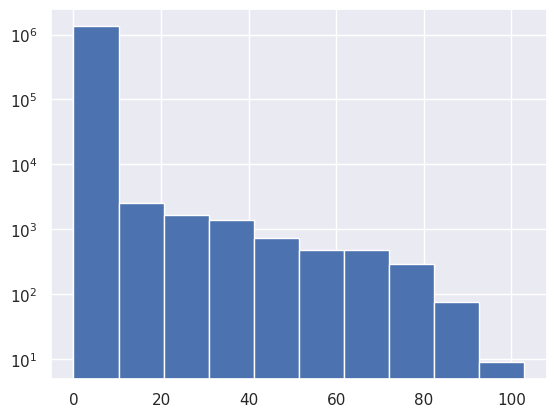

In [10]:
cat.fobs.hist();
plt.yscale('log')

In [17]:
cat.shape

(1361483, 85)

In [16]:
cat.loc[cat['SNR_mean'] >= 0.0].shape

(1334238, 85)

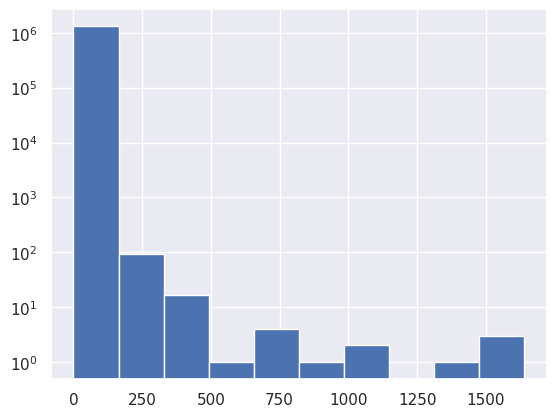

In [14]:
cat.loc[cat['SNR_mean'] >= 0.0].SNR_mean.hist()
plt.yscale('log')

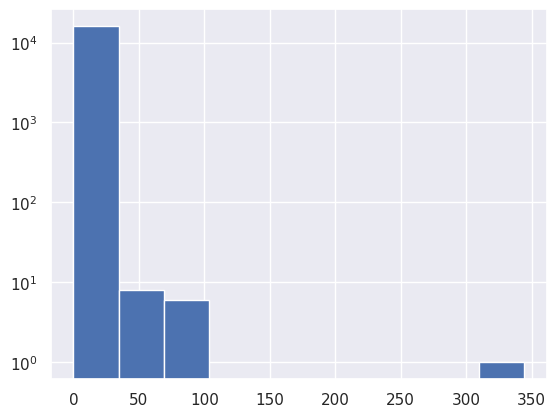

In [21]:
golden.SNR_mean.hist()
plt.yscale('log')

In [9]:
cat.columns

Index(['SWEEP_NAME', 'INDEX_SWEEP', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC',
       'EBV', 'SN_MAX', 'PLXSIG', 'PMSIG', 'BAND_LEGACY', 'REFERENCE_BAND',
       'COMBINATION_USE', 'CAL_MAG_BLUE', 'CAL_MAG_GREEN', 'CAL_MAG_RED',
       'MAG', 'CAL_MAG_ERR_BLUE', 'CAL_MAG_ERR_GREEN', 'CAL_MAG_ERR_RED',
       'MAG_ERR', 'MAG_Y', 'MAG_J', 'MAG_H', 'MAG_K', 'MAGERR_Y', 'MAGERR_J',
       'MAGERR_H', 'MAGERR_K', 'MAG_W1', 'MAG_W2', 'MAGERR_W1', 'MAGERR_W2',
       'P_QSO', 'REDSHIFT_ESTIMATE', 'Z1_QSO', 'Z2_QSO', 'P_QSO_Z', 'P_GALAXY',
       'PHOTOZ_GALAXY', 'Z1_GALAXY', 'Z2_GALAXY', 'P_GALAXY_Z', 'P_STAR',
       'RATIO', 'CLASS_SPEC', 'Z_SPEC', 'REDSHIFT_ERROR', 'REDSHIFT_REF', 'l',
       'b', 'pm', 'PMRA', 'PMDEC', 'pmra_error', 'pmdec_error', 'Z_DESI',
       'SPECTYPE_DESI', 'SUBSURVEY', 'EPOCH', 'RESOLUTION', 'CADENCE',
       'TEMPLATE', 'EXTENT_FLAG', 'EXTENT_PARAMETER', 'EXTENT_INDEX',
       'REDDENING', 'TEMPLATE_REDSHIFT', 'DATE_EARLIEST', 'DATE_LATEST',
       'CLASSIFICATIO

In [10]:
save_to_fits(cat, '/data2/home2/nguerrav/Catalogues/ByCycle_Final_Cat_fobs_qso_templates_with_SNR_golden_label.fits')

### Test set

In [16]:
not_golden.SNR_blue_mean.describe()

count    592776.000000
mean          1.700050
std           5.072829
min           0.001185
25%           0.786858
50%           1.062390
75%           1.647190
max        1153.558651
Name: SNR_blue_mean, dtype: float64

In [22]:
not_golden.loc[not_golden['SNR_blue_mean']>=3.0].shape

(53264, 86)

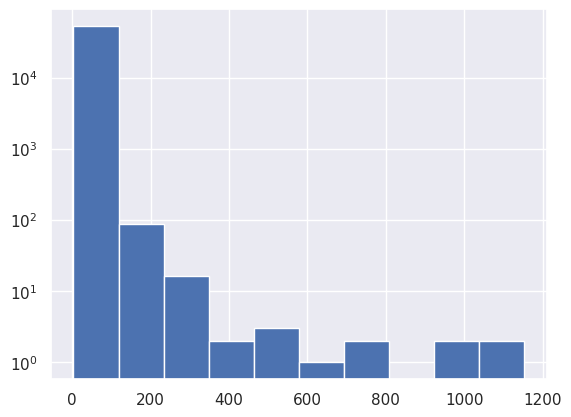

In [25]:
not_golden.loc[not_golden['SNR_blue_mean']>=3.0]['SNR_blue_mean'].hist()
plt.yscale('log')

In [26]:
save_to_fits(not_golden.loc[not_golden['SNR_blue_mean']>=3.0], '/data2/home2/nguerrav/Catalogues/test_set_cat_not_in_golden_sample_SNR_3.fits')

### Look at specs

#### with MgII

In [27]:
cat = pandas_from_fits('/data2/home2/nguerrav/Catalogues/test_set_cat_not_in_golden_sample_SNR_3_with_MgII.fits')

In [28]:
Counter(cat['TEMPLATE_with_MgII'])

Counter({' ': 16,
         'QSO_sim_z1.6_MgIIBlueDeep_1.2627m27.1433_with_MgII.fits': 1,
         'QSO_sim_z1.85_MgIIBlueDeep_2.5972m32.4438_with_MgII.fits': 1,
         'QSO_sim_z2.9_MgIIBlueDeep_2.4143m32.0799_with_MgII.fits': 1,
         'QSO_sim_z2.15_MgIIBlueDeep_3.1165m31.8456_with_MgII.fits': 1,
         'QSO_sim_z1.85_MgIIBlueDeep_3.7311m34.6706_with_MgII.fits': 1,
         'QSO_sim_z2.9_MgIIBlueDeep_4.0411m31.4435_with_MgII.fits': 1,
         'QSO_sim_z2.9_MgIIBlueDeep_3.846m32.0478_with_MgII.fits': 1,
         'QSO_sim_z2.05_MgIIBlueDeep_3.6107m30.3956_with_MgII.fits': 1,
         'QSO_sim_z2.0_MgIIBlueDeep_4.5326m30.2791_with_MgII.fits': 1,
         'QSO_sim_z1.1_MgIIBlueDeep_4.4965m33.9038_with_MgII.fits': 1,
         'QSO_sim_z1.5_MgIIBlueDeep_4.6637m33.3672_with_MgII.fits': 1,
         'QSO_sim_z1.9_MgIIBlueDeep_4.9228m30.6594_with_MgII.fits': 1,
         'QSO_sim_z1.85_MgIIBlueDeep_4.3422m33.0423_with_MgII.fits': 1,
         'QSO_sim_z2.9_MgIIBlueDeep_4.1377m32.7623_with

In [15]:
cat.SNR_blue_mean.describe()

count    53264.000000
mean         7.104474
std         15.849873
min          3.000080
25%          3.531848
50%          4.435443
75%          6.576860
max       1153.558651
Name: SNR_blue_mean, dtype: float64

In [16]:
cat.columns

Index(['SWEEP_NAME', 'INDEX_SWEEP', 'BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC',
       'EBV', 'SN_MAX', 'PLXSIG', 'PMSIG', 'BAND_LEGACY', 'REFERENCE_BAND',
       'COMBINATION_USE', 'CAL_MAG_BLUE', 'CAL_MAG_GREEN', 'CAL_MAG_RED',
       'MAG', 'CAL_MAG_ERR_BLUE', 'CAL_MAG_ERR_GREEN', 'CAL_MAG_ERR_RED',
       'MAG_ERR', 'MAG_Y', 'MAG_J', 'MAG_H', 'MAG_K', 'MAGERR_Y', 'MAGERR_J',
       'MAGERR_H', 'MAGERR_K', 'MAG_W1', 'MAG_W2', 'MAGERR_W1', 'MAGERR_W2',
       'P_QSO', 'REDSHIFT_ESTIMATE', 'Z1_QSO', 'Z2_QSO', 'P_QSO_Z', 'P_GALAXY',
       'PHOTOZ_GALAXY', 'Z1_GALAXY', 'Z2_GALAXY', 'P_GALAXY_Z', 'P_STAR',
       'RATIO', 'CLASS_SPEC', 'Z_SPEC', 'REDSHIFT_ERROR', 'REDSHIFT_REF', 'l',
       'b', 'pm', 'PMRA', 'PMDEC', 'pmra_error', 'pmdec_error', 'Z_DESI',
       'SPECTYPE_DESI', 'SUBSURVEY', 'EPOCH', 'RESOLUTION', 'CADENCE',
       'TEMPLATE', 'EXTENT_FLAG', 'EXTENT_PARAMETER', 'EXTENT_INDEX',
       'REDDENING', 'TEMPLATE_REDSHIFT', 'DATE_EARLIEST', 'DATE_LATEST',
       'CLASSIFICATIO

In [ ]:
cat.loc[cat.EW_MgII_2796 >= 0.0].EW_MgII_2796.describe()

count    53248.000000
mean         0.020714
std          0.161462
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: EW_MgII_2796, dtype: float64

In [26]:
cat.dtypes

SWEEP_NAME              string[python]
INDEX_SWEEP                    float64
BRICKNAME               string[python]
OBJID                          float64
TYPE                    string[python]
                             ...      
EW_MgII_2803                     int64
TEMPLATE_with_MgII      string[python]
EW_MgII_total                    int64
MgII_2796_center_pos             int64
MgII_2796_center_wl              int64
Length: 94, dtype: object

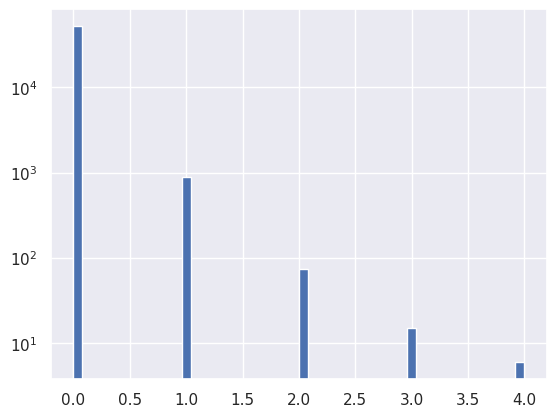

In [25]:
cat.loc[cat.EW_MgII_2796 >= 0.0].EW_MgII_2796.hist(bins=50)
plt.yscale('log')

In [68]:
random_mgii = cat.loc[cat.EW_MgII_2796 >= 2.0].sample(1, random_state=4)
random_mgii

,SWEEP_NAME,INDEX_SWEEP,BRICKNAME,OBJID,TYPE,RA,DEC,EBV,SN_MAX,PLXSIG,...,SNR_red_mean,golden,has_MgII,z_MgII,EW_MgII_2796,EW_MgII_2803,TEMPLATE_with_MgII,EW_MgII_total,MgII_2796_center_pos,MgII_2796_center_wl
17790,065m015-070m010,1102164.0,0695m110,451.0,PSF,69.423144,-11.041218,0.07718,1368.117798,-99.0,...,11.993743,False,True,1,2,1,QSO_sim_z2.9_DLABlue_69.4231m11.0412_with_MgII...,-999,1893,4077


In [69]:
random_mgii[['fobs', 'MAG', 'REDSHIFT_ESTIMATE']]

,fobs,MAG,REDSHIFT_ESTIMATE
17790,1.219516,16.841404,2.9


In [70]:
random_mgii['specname'] = random_mgii.apply(lambda x: spec_name(x,), axis=1)
print(random_mgii['specname'].values[0])

QSO_sim_ETC_z2.9_mag16.84_DLABlue_69.4231m11.0412_LJ1.fits


In [71]:
template_filename_ok = random_mgii.TEMPLATE_with_MgII.values[0]
random_mgii_temp = Table.read(f'/data2/home2/nguerrav/QSO_simpaqs/QSOs_full_cat_with_absorbers_in_blue_arm/{template_filename_ok}')

In [72]:
# random_ok_spec = Table.read(f'/data2/home2/nguerrav/QSO_simpaqs/QSOs_full_cat_ETC_L1_output_with_fobs_etc_grid/{random_mgii['specname'].values[0]}')
random_mgii_spec_L1 = Table.read(f'/data2/home2/nguerrav/QSO_simpaqs/QSOs_full_cat_with_absorbers_in_blue_arm_ETC_L1_output_with_fobs/{random_mgii['specname'].values[0]}')

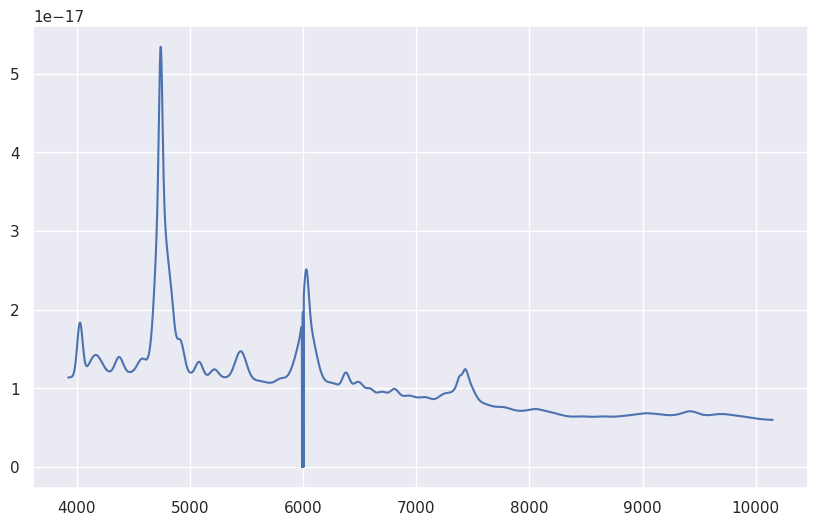

In [73]:
plt.figure(figsize=(10, 6))

plt.plot(random_mgii_temp['LAMBDA'], random_mgii_temp['FLUX_DENSITY'], label='temp')
# plt.plot(random_mgii_spec_L1['WAVE'][0], random_mgii_spec_L1['FLUX'][0], label='L1')

# plt.xlim(3900, 4400)

plt.show()

#### random without MgII

In [ ]:
random_ok = golden.loc[golden.SNR_mean > 3.0].sample(1, random_state=1)

In [ ]:
random_neg_snr = cat.loc[(cat.SNR_mean < 0.0) & (cat['fobs']>= 5.0) & (cat['MAG'] <= 20.0)].sample(1, random_state=1)

In [67]:
# random_neg_snr_spec = spec_name(random_neg_snr)
random_neg_snr['specname'] = random_neg_snr.apply(lambda x: spec_name(x), axis=1)
print(random_neg_snr['specname'].values[0])

QSO_sim_ETC_z2.839_mag19.54_MgIIBlueDeep_193.9183m2.0742_LJ1.fits


In [76]:
random_ok['specname'] = random_ok.apply(lambda x: spec_name(x), axis=1)
print(random_ok['specname'].values[0])

QSO_sim_ETC_z0.9282_mag18.76_MgIIBlueWide_85.6563m72.8589_LJ1.fits


In [68]:
random_neg_snr[['fobs', 'MAG', 'REDSHIFT_ESTIMATE']]

,fobs,MAG,REDSHIFT_ESTIMATE
7003,6.080699,19.543695,2.838961


In [77]:
random_ok[['fobs', 'MAG', 'REDSHIFT_ESTIMATE']]

,fobs,MAG,REDSHIFT_ESTIMATE
14253,14.137356,18.755318,0.928191


In [78]:
template_filename_ok = random_ok.TEMPLATE.values[0]
random_ok_temp = Table.read(f'/data2/home2/nguerrav/QSO_simpaqs/QSOs_full_cat/{template_filename_ok}')

In [80]:
random_ok_spec = Table.read(f'/data2/home2/nguerrav/QSO_simpaqs/QSOs_full_cat_ETC_L1_output_with_fobs_etc_grid/{random_ok['specname'].values[0]}')
random_ok_spec_L1 = Table.read(f'/data2/home2/nguerrav/QSO_simpaqs/QSOs_full_cat_ETC_L1_output_with_fobs/{random_ok['specname'].values[0]}')

In [69]:
template_filename = random_neg_snr.TEMPLATE.values[0]
random_neg_snr_temp = Table.read(f'/data2/home2/nguerrav/QSO_simpaqs/QSOs_full_cat/{template_filename}')

In [70]:
random_neg_snr_spec = Table.read(f'/data2/home2/nguerrav/QSO_simpaqs/QSOs_full_cat_ETC_L1_output_with_fobs_etc_grid/{random_neg_snr['specname'].values[0]}')
random_neg_snr_spec_L1 = Table.read(f'/data2/home2/nguerrav/QSO_simpaqs/QSOs_full_cat_ETC_L1_output_with_fobs/{random_neg_snr['specname'].values[0]}')

In [71]:
random_neg_snr_spec_L1

WAVE,FLUX,ERR_FLUX,QUAL,FLUX_NOSS,ERR_FLUX_NOSS
Angstrom,erg / (Angstrom s cm2),erg / (Angstrom s cm2),,erg / (Angstrom s cm2),erg / (Angstrom s cm2)
float32[33775],float32[33775],float32[33775],int32[33775],float32[33775],float32[33775]
3926.10 .. 6789.90,-8.56618e-31 .. -8.04014e-33,-- .. --,0 .. 0,4.02940e-17 .. 3.02749e-17,-- .. --


In [72]:
random_neg_snr_spec_L1['FLUX']

-8.56618e-31 .. -8.04014e-33


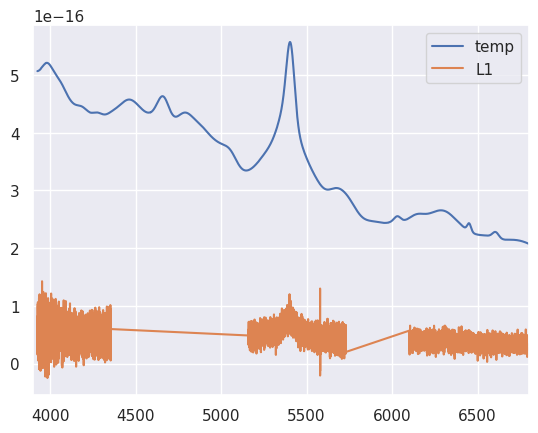

In [83]:
plt.plot(random_ok_temp['LAMBDA'], random_ok_temp['FLUX_DENSITY'], label='temp')
plt.plot(random_ok_spec_L1['WAVE'][0], random_ok_spec_L1['FLUX'][0], label='L1')
plt.legend()
plt.xlim(3900, 6800)
plt.show()

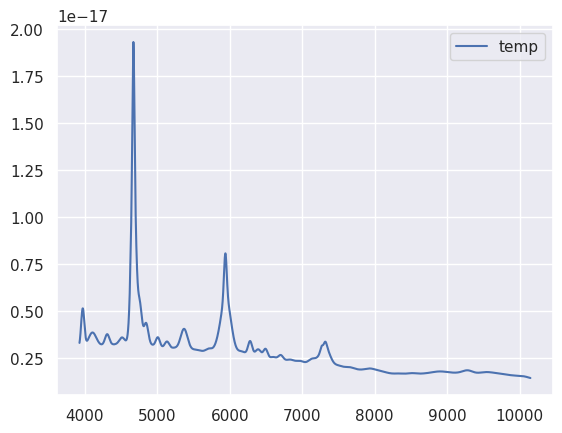

In [82]:
plt.plot(random_neg_snr_temp['LAMBDA'], random_neg_snr_temp['FLUX_DENSITY'], label='temp')
# plt.plot(random_neg_snr_spec_L1['WAVE'][0], random_neg_snr_spec_L1['FLUX'][0], label='L1')
plt.legend()
plt.show()

(6000.0, 6800.0)

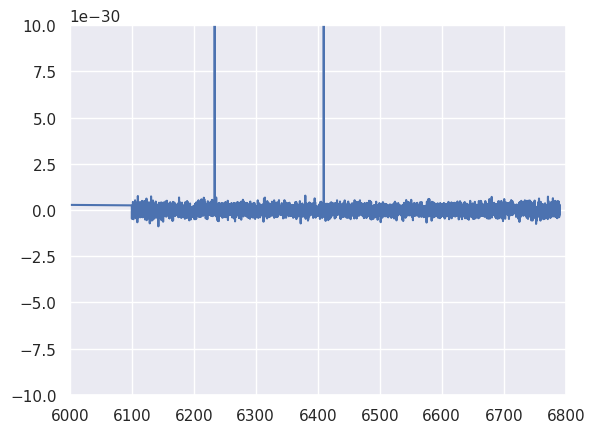

In [57]:
plt.plot(random_neg_snr_spec_L1['WAVE'][0], random_neg_snr_spec_L1['FLUX'][0])
plt.ylim(-0.1e-28, 0.1e-28)
plt.xlim(6000, 6800)

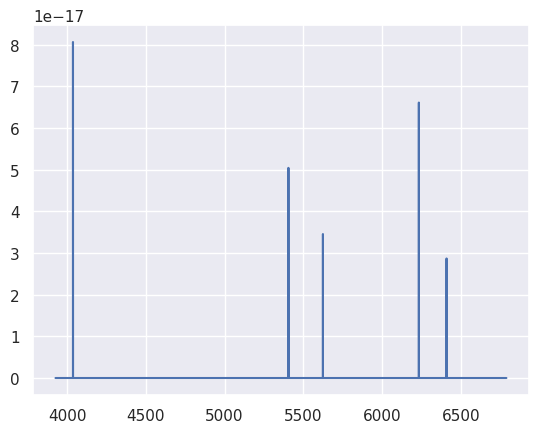

In [46]:
plt.plot(random_neg_snr_spec['WAVE'], random_neg_snr_spec['FLUX'])